In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

In [ ]:
NUM_OF_CYCLES = 50

# Feature selection

Feature selection techniques are used in conjunction with ML algorithms to achive several goals:

- improve training: random forest and gradient boosting models can train to suboptimal state, when presented with too many likely irrelevant features,
- speed-up training,
- make model more interpretable (it's hard to do when you have tons of models),
- make model more stable, less noisy.

Generally, you need to use targets to select features, cause the story is about selecting the festures, which have some information about target. Also, there's no need to do any feature selection, if you have only few features. Two main scenarios, when you need to do feature selection are:

- you have too many original features, so that you train slowly and model struggles,
- you create a lot of derived features and do not know, which are good and which are not.

In this exercise we won't do feature construction, we will just take dataset with enough features in it. Also, remember this:

- some features may look like irrelevant on their own, but when transformed (e.g. $x\rightarrow 1/x$) or combined with other features, they suddenly start to play very well,
- this means, that you do feature generation first, only then start to filter them.

# *Don't Overfit! II* challenge

We will use [dataset](https://www.kaggle.com/c/dont-overfit-ii) from Kaggle.

In [3]:
tr_data = pd.read_csv("/home/ubuntu/unsu/exe2/dont-overfit-ii/train.csv", index_col="id")

In [4]:
tr_data.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [5]:
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Columns: 301 entries, target to 299
dtypes: float64(301)
memory usage: 589.8 KB


In [6]:
tr_data.isnull().any().any()

False

Let's note several things:

- we have only numerical features,
- we do not have null values.

Both simplify things a bit, but the general principles are the same.

# Selecting features

Feature selection may be done in several ways:

- you can directly calculate some information measure (usually, mutual information or correlation of some sort) and select most informative features,
- you can select features from some model, which knows how to estimate feature importance (random forest and gradient boosting are good examples),
- you can have feature selection as a part of your model by e.g. L1 regularization, which will drive coefficients for irrelevant features to 0. Although this saves no computational time, you will get sparse and hopefully well-behaving model.

We will consider first two approaches, and you may play with `Lasso` to understand the third approach.

# Correlations and mutual information

Since we have numerical features only, we can start from correlation as an information measure.

In [7]:
from scipy.stats import pearsonr

In [8]:
?pearsonr

In [8]:
crs = {}

for cl in tr_data.columns[1:]:
    cr, _ = pearsonr(tr_data[cl], tr_data["target"])
    crs[cl] = cr
crs = pd.Series(crs)

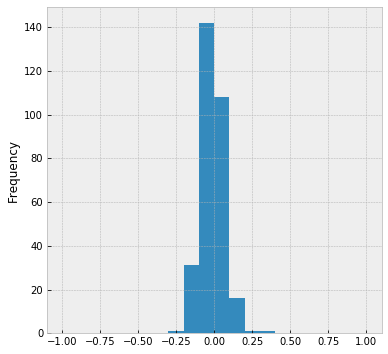

In [9]:
plt.figure(figsize=(6,6))
crs.plot(kind="hist", range=[-1, 1], bins=20, ax=plt.gca())

So, most of the features are below `0.2` in either direction. We can select the features, which are the most correlated with some threshold, but let's look at mutual information first.

The difference is that correlation coefficient can only quantify linear realtions, while mutual information can quantify any relation (in theory).

To apply mutual information, we first need to quantize own features. We will use quantiles `25, 50, 75` as bins edges. target is already binary, so we leave it as it is.

In [10]:
from sklearn.metrics import mutual_info_score

In [11]:
mis = {}

for cl in tr_data.columns[1:]:
    qs = np.percentile(tr_data[cl], q=(25, 50, 75))
    qz = np.digitize(tr_data[cl], qs)
    mis[cl] = mutual_info_score(tr_data["target"], qz)
mis = pd.Series(mis)

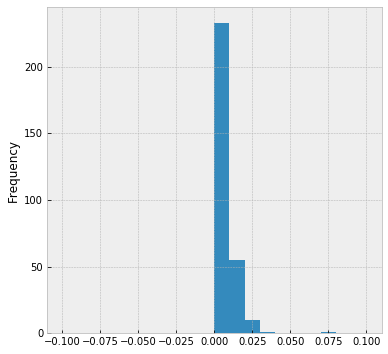

In [12]:
plt.figure(figsize=(6,6))
mis.plot(kind="hist", range=[-0.1, 0.1], bins=20, ax=plt.gca())

Now, the question is: how correlation and MI are related? May it be, that some features have low correlation, but high mutual information?

Text(0, 0.5, 'MI')

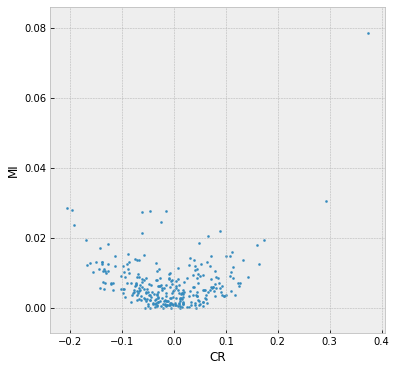

In [13]:
plt.figure(figsize=(6,6))

plt.scatter(crs, mis, s=4)
plt.xlabel("CR")
plt.ylabel("MI")

So, there are at least several features, which have high correlation, but **relatively** low MI.

**Question:** how is that possible, since MI is more generic measure?

Let's test drive with feature sets: one with very strict selection (only the very best features) and another one with more relaxed one. And no, fitting a real model with all the features, while having this few training examples is not a good idea. You need to treat this situation first.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [15]:
# Cheap substitution for shuffle split
tr_idx = np.random.choice(tr_data.shape[0], 150, replace=False)
cv_idx = tr_data.index.difference(tr_idx)

In [16]:
low_thr, high_thr = np.percentile(mis, q=[75, 90])

In [17]:
low_features = mis[mis>=low_thr].index
high_features = mis[mis>=high_thr].index

In [18]:
for features in [low_features, high_features]:
    model = RandomForestClassifier(n_estimators=100, max_depth=4)
    model.fit(tr_data.loc[tr_idx, features], tr_data.loc[tr_idx, "target"])
    print("Training set:")
    print(classification_report(tr_data.loc[tr_idx, "target"],
                                model.predict(tr_data.loc[tr_idx, features])))
    
    print("CV set:")
    print(classification_report(tr_data.loc[cv_idx, "target"],
                                model.predict(tr_data.loc[cv_idx, features])))

Training set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        56
         1.0       1.00      1.00      1.00        94

   micro avg       1.00      1.00      1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

CV set:
              precision    recall  f1-score   support

         0.0       0.83      0.29      0.43        34
         1.0       0.73      0.97      0.83        66

   micro avg       0.74      0.74      0.74       100
   macro avg       0.78      0.63      0.63       100
weighted avg       0.76      0.74      0.70       100

Training set:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        56
         1.0       0.94      1.00      0.97        94

   micro avg       0.96      0.96      0.96       150
   macro avg       0.97      0.95      0.96       150
weighted avg       0.96      0.96     

You can immediately see the difference: model with fewer features performs better.

# Selecting from model

Now that we pre-selected some features, we can go further and do selection from model. Generally, any model with features importances calculation will work, but the simplest choice is, of course, random forest.

In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=4)
model.fit(tr_data.loc[tr_idx, low_features], tr_data.loc[tr_idx, "target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
imprts = pd.Series(model.feature_importances_, index=low_features, name="importance").sort_values(ascending=False)

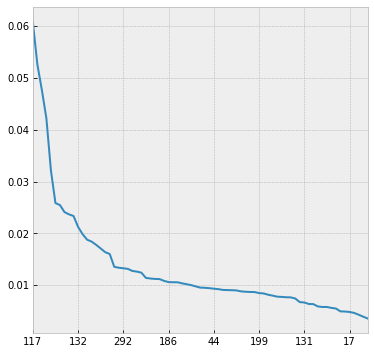

In [21]:
plt.figure(figsize=(6,6))
imprts.plot()

So, the model says, that there are no irrelevant features, although there are some marginally important ones. Let's test this: we will eliminate features one by one and train a model to see, how this influences the performance.

In [22]:
roc_aucs = {}

for i in range(1, 50):
    COLS = imprts.iloc[:-i].index

    model = RandomForestClassifier(n_estimators=100, max_depth=4)
    model.fit(tr_data.loc[tr_idx, COLS], tr_data.loc[tr_idx, "target"])

    roc_aucs[imprts.shape[0]-i] = roc_auc_score(tr_data.loc[cv_idx, "target"],
                                                model.predict_proba(tr_data.loc[cv_idx, COLS])[:, 1])
roc_aucs = pd.Series(roc_aucs)

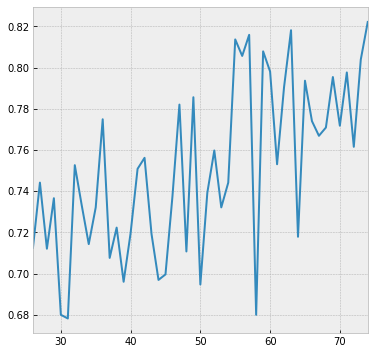

In [23]:
plt.figure(figsize=(6,6))
roc_aucs.plot()

**Question:** what's wrong with this plot?

Do the following:

- add proper sampling: re-train model multiple times with different splits/different random seeds to smooth the plot above,
- consider `sklearn.feature_selection.RFECV`. Is it different from what you just did?
- play with `sklearn.linear_model.LogisticRegression` and `l1` penalty to obtain sparse model. Would resulting set of features be similar to what you got from random forest?

In [33]:
roc_aucs = {}
SMOOTHING = 10
for i in range(1, 50):
    COLS = imprts.iloc[:-i].index
    
    scores = 0.0
    for train_index in range(SMOOTHING):
        tr_idx = np.random.choice(tr_data.shape[0], 150, replace=False)
        cv_idx = tr_data.index.difference(tr_idx)
    

        model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state = i * train_index)
        model.fit(tr_data.loc[tr_idx, COLS], tr_data.loc[tr_idx, "target"])
        score = roc_auc_score(tr_data.loc[cv_idx, "target"],
                                                model.predict_proba(tr_data.loc[cv_idx, COLS])[:, 1])
        
        scores += score

    roc_aucs[imprts.shape[0]-i] = scores/SMOOTHING
    
roc_aucs = pd.Series(roc_aucs)

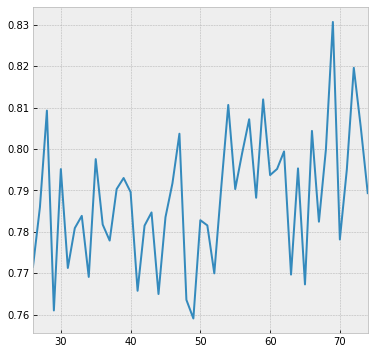

In [34]:
plt.figure(figsize=(6,6))
roc_aucs.plot()

In [40]:

from sklearn.feature_selection import RFECV
train_df = tr_data.loc[tr_idx, ~tr_data.columns.isin(['target'])]
validations_df = tr_data.loc[cv_idx, ~tr_data.columns.isin(['target'])]
roc_aucs = {}
for i in range(1, NUM_OF_CYCLES):    
    rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state = 999)
    model = RFECV(rf, step=i, scoring='accuracy')
    
    model.fit(train_df, tr_data.loc[tr_idx, "target"])
    
    roc_aucs[NUM_OF_CYCLES - i] = roc_auc_score(tr_data.loc[cv_idx, "target"],
                                                model.predict_proba(validations_df)[:, 1])
    
roc_aucs = pd.Series(roc_aucs)

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of rely

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of rely

In [42]:
plt.figure(figsize=(6,6))
roc_aucs.plot()

71    0.004697
Name: importance, dtype: float64

In [47]:
from sklearn.linear_model import LogisticRegression

train_df = tr_data.loc[tr_idx, ~tr_data.columns.isin(['target'])]
validations_df = tr_data.loc[cv_idx, ~tr_data.columns.isin(['target'])]

roc_aucs = {}
for i in range(1, NUM_OF_CYCLES): 
    
    logistcReg = LogisticRegression(penalty='l1', solver='liblinear', C= i)
    model = RFECV(logistcReg, scoring ='accuracy', step=20, cv=5, min_features_to_select=2)
    model.fit(train_df, tr_data.loc[tr_idx, "target"])
    roc_aucs[NUM_OF_CYCLES - i] = roc_auc_score(tr_data.loc[cv_idx, "target"], model.predict_proba(validations_df)[:, 1])
    
roc_aucs = pd.Series(roc_aucs)


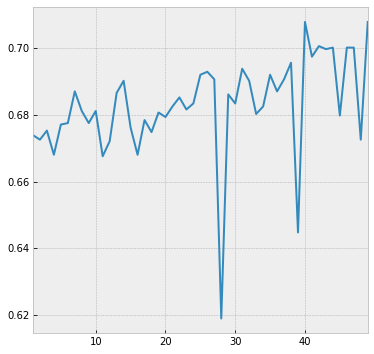

In [48]:
plt.figure(figsize=(6,6))
roc_aucs.plot()